In [ ]:
## Project: Building a Traffic Sign Recognition Classifier

In this project we make use of Convolutional Neural Network (CNN) to classify traffic signs. The CNN model was trained
and validated using the [German Traffic Sign dataset](http://benchmark.ini.rub.de/). The model was also tested on 
images of German traffic signs downloaded from the Internet.

Following results were obtained with the trained CNN model.

  * Validation accuracy : 96.9%
  * Test accuracy : 94.8%

---
## Step 0: Load The Data

In [7]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data
dataset_dir = './dataset'
sign_names_file = './signnames.csv'

training_file = dataset_dir + '/train.p'
validation_file = dataset_dir + '/valid.p'
testing_file = dataset_dir + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
sign_names = load_sign_names()


### Helper methods

In [18]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import pickle
from tqdm import tqdm
from time import sleep
import os
import glob

def load_sign_names(sign_names_file='./signnames.csv'):
    """
    Loads the CSV file containing traffic sign names.
    :param sign_names_file: Path to the sign-names CSV file.
    :return: A list containing sign-names, indexed by_set their label-class-number (known).
    """
    signs_list = []
    with open(sign_names_file, mode='r') as labels_file:
        reader = csv.reader(labels_file)
        next(reader, None)
        for sign in reader:
            signs_list.append(sign[1])
    return signs_list

def visualize_dataset(X, y, sign_names):
    """
    Displays 12 images randomly from the given dataset.
    """
    # Divide the display region by 4x3 cells for displaying 12 random images.
    rows = 4
    columns = 3
    fig = plt.figure(figsize=(20,15))
    fig.subplots_adjust(hspace = .75, wspace=.001)
    for i in range(1, rows * columns + 1):
        img_idx = np.random.randint(0, len(X))
        sign_image = X[img_idx]
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(sign_names[y[img_idx]])
        ax.title.set_fontsize(10)
        plt.axis('off')
        plt.imshow(sign_image)

def describe_labels(y, sign_names, count_plot_name=None):
    """
    Provides insight on the count of each sign-label in the labels-set.
    """
    sign_dict = dict(zip([idx for idx in range(len(sign_names))], sign_names))
    y_labels = list(map(lambda sign_num : sign_names[sign_num], y))
    y_df = pd.DataFrame(y_labels, dtype=str, columns=['sign_name'])
    cnt_plot = sns.factorplot(x=y, data=y_df, kind='count', size=8, aspect=1.2, color=".4")
    cnt_plot.set_xlabels('Traffic sign class')
    cnt_plot.fig.suptitle(count_plot_name, size=20)
    # print('### Label index (vs) Sign name map ###')
    # print(pd.DataFrame(list(sign_dict.values()), columns=['Sign Name']))
    # print('\n')
    print('### Sign counts ###')
    print(y_df['sign_name'].value_counts())
    
def convert_to_grayscale(X):
    """
    Converts an RGB image having 3 channels to grayscale.
    :param X: RGB image set, each image represented as an ndarray.
    :return: Grayscale images.
    """
    return np.sum(X / 3, axis=3, keepdims=True)

def min_max_scale_grayscale_images(X, scale_min=0.1, scale_max=0.9):
    """
    Applies min-max scaling to make the pixel values fall in the range [scale_min, scale_max]
    :param X: Set of images, type ndarray.
    :return: Min-max scaled images.
    """
    grayscale_min = 0
    grayscale_max = 255
    return scale_min + ((X - grayscale_min) / (grayscale_max - grayscale_min)) * (scale_max - scale_min)

def normalize_images(X):
    return (X - np.mean(X)) / np.std(X)

def quick_normalize_images(X):
    return (X - 128) / 128
    
def preprocess_images(X):
    """
    Applies preprocessing pipeline on the images.
    :param X: Input image dataset.
    :return: Preprocessed image dataset.
    """
    X_gray = convert_to_grayscale(X)
    return normalize_images(X_gray)

def random_translate(img, trans_range=3):
    """
    Translates the image in both x and y directions.
    Range for pixel-translation is set to -2 to 2.
    :param img: Input image.
    :param trans_range: Range, in pixels, to translate the image by.
    :return: Translated image.
    """
    height,width = img.shape[:2]
    dx = dy = np.random.uniform(trans_range) - trans_range / 2
    translation_mat = np.float32([[1,0,dx],[0,1,dy]])
    return cv2.warpAffine(img, translation_mat, (height,width))

def random_shear(img, shear_range=10):
    """
    Shears the image (stretch or shrink) by defining a pair of three points.
    :param img: Input image.
    :param shear_range: Amount of shearing, in pixels, to be applied on the image.
    :return: Sheared image.
    """
    height,width = img.shape[:2]
    # Defining shear limits with a pair of 3-points.
    px = 5 + shear_range * np.random.uniform() - shear_range / 2
    py = 20 + shear_range * np.random.uniform() - shear_range / 2
    shear_src = np.float32([[5,5],[20,5],[5,20]])
    shear_dst = np.float32([[px,5],[py,px],[5,py]])
    shear_mat = cv2.getAffineTransform(shear_src, shear_dst)
    return cv2.warpAffine(img, shear_mat, (height,width))

def random_rotate(img, angle_range=20):
    """
    Rotates the image by a certain angle.
    :param img: Input image.
    :param angle_range: Range of the angle of rotation, in pixels.
    :return: Rotated image.
    """
    height,width = img.shape[:2]
    rot_angle = np.random.uniform(angle_range) - angle_range / 2
    rot_mat = cv2.getRotationMatrix2D((height/2,width/2), rot_angle, 1)
    return cv2.warpAffine(img, rot_mat, (height,width))

def random_brightness(img):
    r_brightness = 0.3 + np.random.uniform()
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = r_brightness * img_hsv[:,:,2]
    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

def augment_jitter_data(X, y, min_num_samples=750):
    num_classes = len(np.unique(y))
    print('Augmenting data for classes which have < {} samples ..'.format(min_num_samples))
    augmented_train_set = {}
    for sample_class in range(num_classes):
        sample_indices = np.where(sample_class == y)
        num_samples = len(sample_indices[0])
        if num_samples < min_num_samples:
            print('\nClass {}: {} samples, {} samples to augment'.format(sample_class, num_samples, min_num_samples-num_samples))
            sleep(0.1)
            # Augment samples for this class by applying geometric transformation on existing images
            # having the same class.
            for i in range(min_num_samples - num_samples):
                img = X[sample_indices[0][i % num_samples]]
                transformed_img = random_shear(random_translate(random_rotate(random_brightness(img))))
                X = np.concatenate((X, [transformed_img]), axis=0)
                y = np.concatenate((y, [sample_class]), axis=0)
            sleep(0.5)
    augmented_train_set['features'] = X
    augmented_train_set['labels'] = y
    pickle.dump(augmented_train_set, open('augmented_train.p', 'wb'))
    return X, y


---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

  * There are 34799, 4410 and 12630 samples in train, validation and test sets respectively.
  * Image dimension inside this dataset is 32x32x3.
  * Number of classes is 43.

In [20]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Image dimensions: {}".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Image dimensions: (32, 32, 3)
Training Set:   47780 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Number of training examples = 47780
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

### Displaying random images from the dataset

Note: Few images' brightness tend to be poor which can be hard to distinguish to naked eyes.

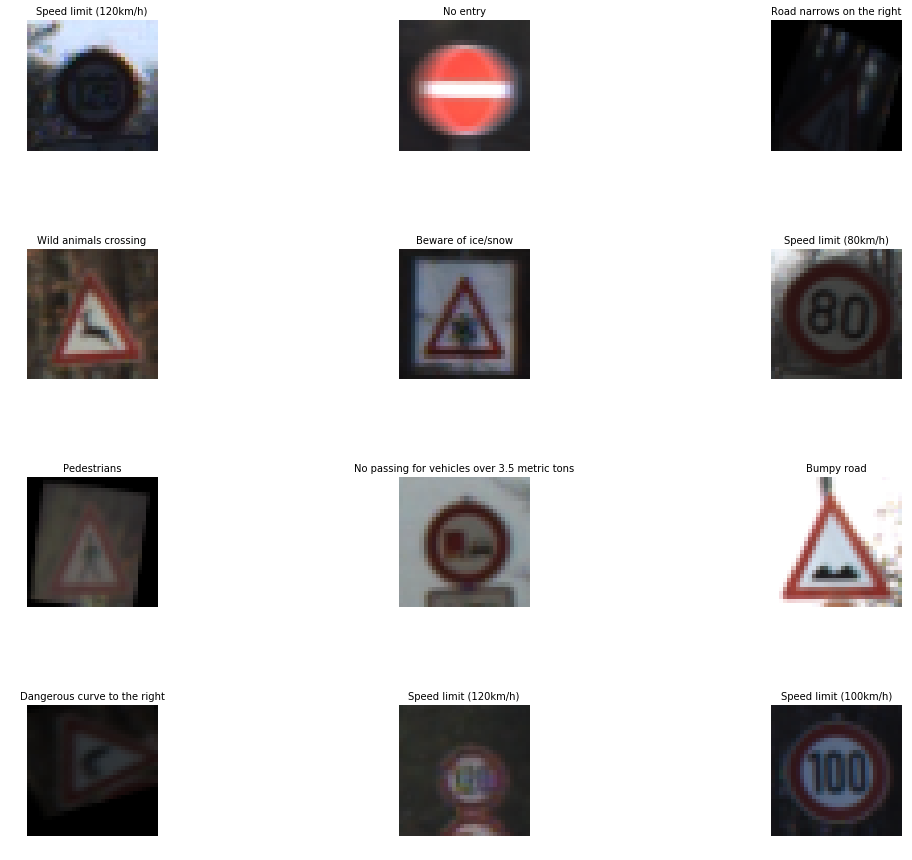

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
visualize_dataset(X_train, y_train, sign_names)


### Dataset description

Below provided is the histogram of sign counts, along with a table containing their actual values,
for each of train, validation and test sets.

#### Training set labels

### Sign counts ###
Speed limit (50km/h)                                  2010
Speed limit (30km/h)                                  1980
Yield                                                 1920
Priority road                                         1890
Keep right                                            1860
No passing for vehicles over 3.5 metric tons          1800
Speed limit (70km/h)                                  1770
Speed limit (80km/h)                                  1650
Road work                                             1350
No passing                                            1320
Speed limit (100km/h)                                 1290
Speed limit (60km/h)                                  1260
Speed limit (120km/h)                                 1260
Right-of-way at the next intersection                 1170
General caution                                       1080
Ahead only                                            1080
No entry                            

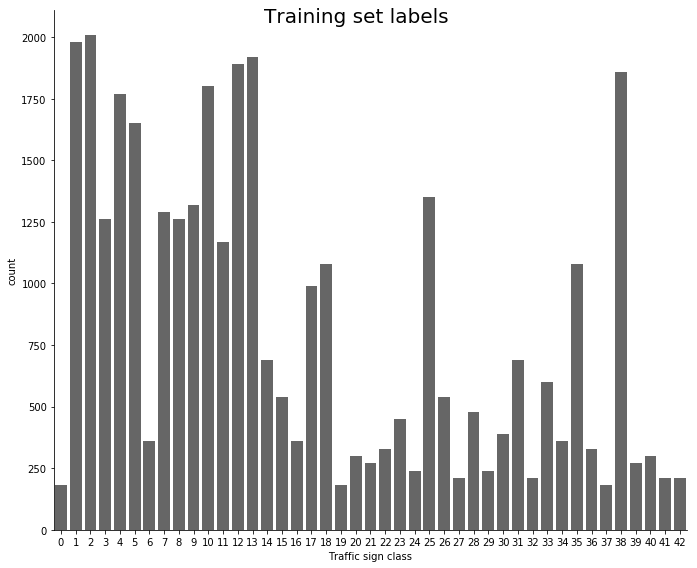

In [11]:
describe_labels(y_train, sign_names, 'Training set labels')

#### Validation set labels

### Sign counts ###
Yield                                                 240
Speed limit (30km/h)                                  240
Speed limit (50km/h)                                  240
No passing for vehicles over 3.5 metric tons          210
Keep right                                            210
Speed limit (70km/h)                                  210
Speed limit (80km/h)                                  210
Priority road                                         210
Right-of-way at the next intersection                 150
Speed limit (120km/h)                                 150
No passing                                            150
Road work                                             150
Speed limit (100km/h)                                 150
Speed limit (60km/h)                                  150
General caution                                       120
Ahead only                                            120
No entry                                            

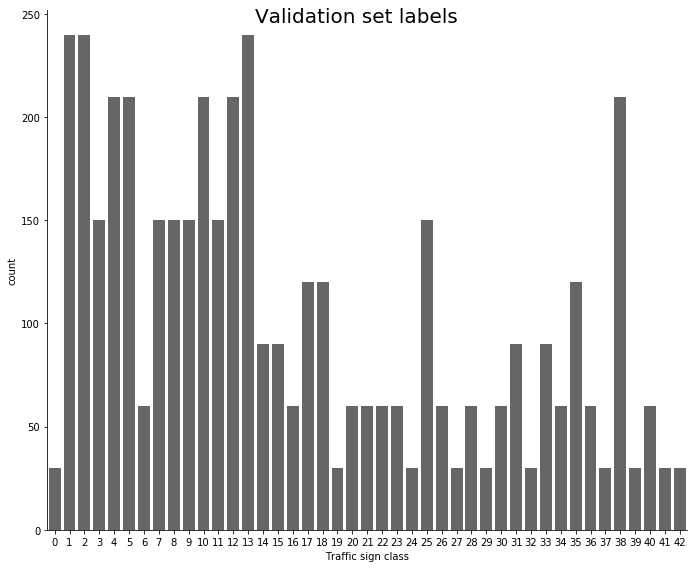

In [12]:
describe_labels(y_valid, sign_names, 'Validation set labels')

#### Test set labels

### Sign counts ###
Speed limit (50km/h)                                  750
Yield                                                 720
Speed limit (30km/h)                                  720
Priority road                                         690
Keep right                                            690
No passing for vehicles over 3.5 metric tons          660
Speed limit (70km/h)                                  660
Speed limit (80km/h)                                  630
Road work                                             480
No passing                                            480
Speed limit (120km/h)                                 450
Speed limit (60km/h)                                  450
Speed limit (100km/h)                                 450
Right-of-way at the next intersection                 420
General caution                                       390
Ahead only                                            390
No entry                                            

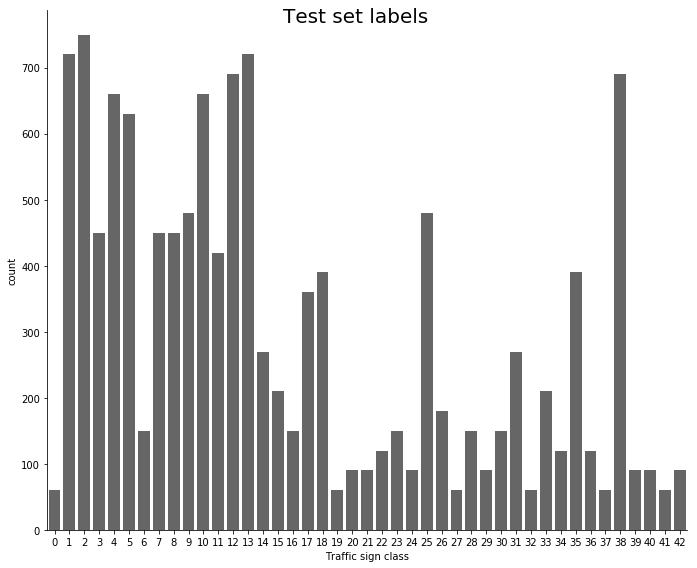

In [13]:
describe_labels(y_test, sign_names, 'Test set labels')

----

## Step 2: Designing and Testing a Model Architecture

### Pre-processing the Data Set

  * Above description of the distribution of labels show that not all classes have equal number of samples.
  This is a potential issue where the model could underfit on classes having high number of samples. 

  * A *jitter-pipeline* is used to overcome this (to an extent) where each class is augmented with samples from its
  own class if it has less than a given number of samples (set to 850). This ensures that each class at least holds
  850 samples during the training stage.

  * Augmented data is picked from existing images (having the same label) and is obtained by 
  performing geometric-transformations on those images, as CNNs are invariant to such transformations i.e. rotation,
  translation, shearing, etc.

Please note that this *augmented-train* set was pickled to be used for future usage. This part is commented
out below and took ~10 minutes to finish.

In [17]:
# Augmenting jitter data to classes/labels which have less than 850 samples.
# X_train, y_train = augment_jitter_data(X_train, y_train, 850)
with open('augmented_train.p', mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']
print(X_train.shape)

(47780, 32, 32, 3)


#### Sample augmented images

Following is a set of images of **No vehicles** and **Beware of ice/snow** signs which were augmented to the
existing set of train samples to their respective class' samples.

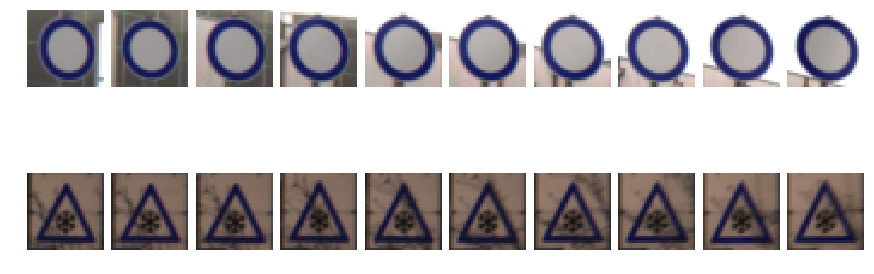

In [96]:
nvehicle_indices = np.where(15 == y_train)[0]  # Class label of No vehicles sign is 15.
icesnow_indices = np.where(30 == y_train)[0]  # Class label of Beware of ice/snow sign is 30.
# Fetching last 10 image index values.
nv_idx = nvehicle_indices[-10:]
isnow_idx = icesnow_indices[-10:]
fig,ax = plt.subplots(2, 10, figsize=(15,6))
fig.subplots_adjust(hspace=.0001, wspace=.1)
ax = ax.ravel()
for i in range(10):
    ax[i].axis('off')
    ax[i].imshow(cv2.cvtColor(X_train[nv_idx[i]], cv2.COLOR_BGR2RGB))
for i in range(10):
    ax[i+10].axis('off')
    ax[i+10].imshow(cv2.cvtColor(X_train[isnow_idx[i]], cv2.COLOR_BGR2RGB))

#### Pre-processing steps

Apart from data augmentation, following preprocessing steps were carried out on all of the images of the dataset
(train, validation and test sets).

  1. Conversion to grayscale : RGB images were converted to grayscale, utilizes less processing power with respect
    to the network parameters.
  2. Normalizing the images : Two variants of normalization were performed on each of the train, validation and test 
    sets.
    * One which does (lazy/quick) normalization on the images which is (X-128) / 128.
    * The other which tries to center (globally) the mean of the image pixel values to 0, with uniform
    standard deviation of 1 : (X - mean(X)) / stddev(X).
        
Among the two normalization techniques, the latter one showed better performance on validation accuracies and
was chosen. It is noted that a better normalization could be the one where each image (locally) is centered at
0 mean with uniform standard-deviation but this would be quite an expensive process.

#### Images before pre-processing

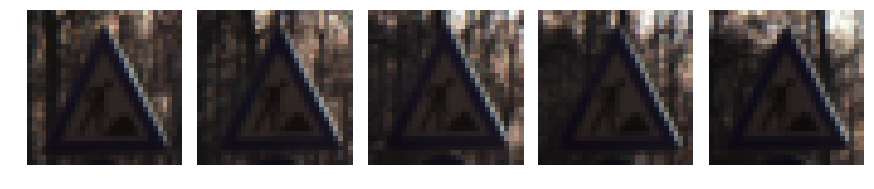

In [97]:
rimg_indices = np.where(25 == y_train)[0]  ## Picking class 25's indices for display.
rimg_idx = rimg_indices[-5:]
fig,ax = plt.subplots(1, 5, figsize=(15,6))
fig.subplots_adjust(hspace=.0001, wspace=.1)
ax = ax.ravel()
for i in range(5):
    ax[i].axis('off')
    ax[i].imshow(cv2.cvtColor(X_train[rimg_idx[i]], cv2.COLOR_BGR2RGB))


In [99]:
X_train = preprocess_images(X_train)
X_valid = preprocess_images(X_valid)
X_test = preprocess_images(X_test)

#### Images after pre-processing

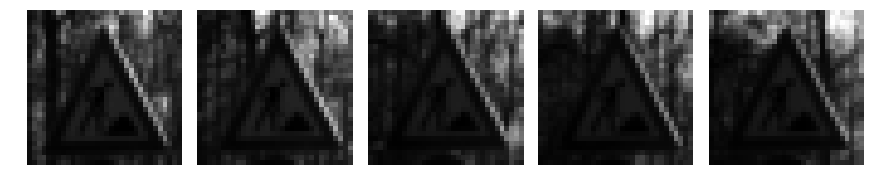

In [101]:
fig,ax = plt.subplots(1, 5, figsize=(15,6))
fig.subplots_adjust(hspace=.0001, wspace=.1)
ax = ax.ravel()
for i in range(5):
    ax[i].axis('off')
    ax[i].imshow(X_train[rimg_idx[i]].squeeze(), cmap='gray')

#### Augmented training set labels' description

### Sign counts ###
Speed limit (50km/h)                                  2010
Speed limit (30km/h)                                  1980
Yield                                                 1920
Priority road                                         1890
Keep right                                            1860
No passing for vehicles over 3.5 metric tons          1800
Speed limit (70km/h)                                  1770
Speed limit (80km/h)                                  1650
Road work                                             1350
No passing                                            1320
Speed limit (100km/h)                                 1290
Speed limit (120km/h)                                 1260
Speed limit (60km/h)                                  1260
Right-of-way at the next intersection                 1170
Ahead only                                            1080
General caution                                       1080
No entry                            

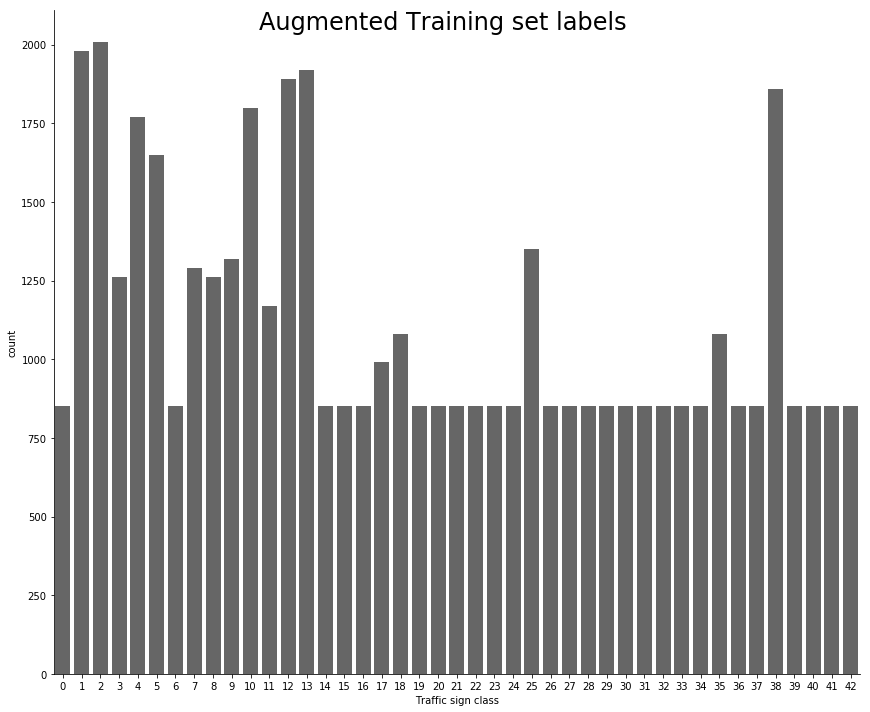

In [15]:
describe_labels(y_train, sign_names, 'Augmented Training set labels')

### Model Architecture

#### CNN architectures

Three variants of LeNet architecture were experimented with.
    
  1. One having dropout applied on the units of fully-connected layers (two in number).
    
  2. Variant of the architecture as described in Sermanet '11 paper on Traffic sign classification.
    In this version, activations from layer 2 (flattened) were passed to the classifier
    (a fully-connected layer) along with activations from layer 3 (convolved and flattened).
    According to the paper, doing so provides "different scales of receptive fields to the classifier"
    i.e. both global and invariant features from the penultimate layer (with respect to the fully-connected layer)
    as well as the local features from the layer before the penultimate one are extracted and hence passed
    to the classifier for better classification.
    
  3. Variant of LeNet with one additional fully-connected layer, making it a total of three fully-connected layers.
  
My final model architecture consisted of the following.

| Layer          | Description                                           |
|----------------|------------------------------------------------------:|
| Input          | 32x32x1 grayscale image                               |
| Convolutional (Layer 1)  | 1x1 stride, valid padding. Output = 28x28x6           |
| ReLu           |   |
| Max-pooling    | 2x2 stride, valid padding. Output = 14x14x6           |
| Convolutional (Layer 2)  | 1x1 stride, valid padding. Output = 10x10x16          |
| ReLu           |   |
| Max-pooling    | 2x2 stride, valid padding. Output = 5x5x16 |
| Fully connected 1 (Layer 3) | Input = 400. Output = 120
| ReLu           |   |
| Dropout        | Dropout on activations, with keep-probability of 0.5 |
| Fully connected 2 (Layer 4) | Input = 120. Output = 84 |
| ReLu           |   |
| Dropout        | Dropout on activations, with keep-probability of 0.5 |
| Classifer  (Layer 5) | Input = 84. Output = 43 | 
| Softmax        |   |

In [18]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    return tf.nn.bias_add(x, b)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def build_lenet(x, keep_prob=0.5):
    '''
    LeNet architecture with dropout applied for the activations of fully-connected layers.
    '''
    mu = 0
    sigma = 0.1

    weights = {
        'fw1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
        'fw2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
        'fcw1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma)),
        'fcw2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma)),
        'fcw3': tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    }

    biases = {
        'b1': tf.Variable(tf.zeros(6)),
        'b2': tf.Variable(tf.zeros(16)),
        'fcb1': tf.Variable(tf.zeros(120)),
        'fcb2': tf.Variable(tf.zeros(84)),
        'fcb3': tf.Variable(tf.zeros(43))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['fw1'], biases['b1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['fw2'], biases['b2'])

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)

    # Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    conv3 = tf.add(tf.matmul(conv2, weights['fcw1']), biases['fcb1'])

    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Dropout.
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    conv4 = tf.add(tf.matmul(conv3, weights['fcw2']), biases['fcb2'])

    # Activation.
    conv4 = tf.nn.relu(conv4)
    
    # Dropout.
    conv4 = tf.nn.dropout(conv4, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(conv4, weights['fcw3']), biases['fcb3'])
    return logits

def build_lenet2(x, keep_prob=0.5):
    '''
    LeNet architecture with a trial on passing activations of a non-penultimate layer
    (with respect to classification-layer)to the classifier. Inspired by Sermanet '11 paper.
    '''
    mu = 0
    sigma = 0.1

    weights = {
        'fw1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
        'fw2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
        'fw3': tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean=mu, stddev=sigma)),
        'fcw1': tf.Variable(tf.truncated_normal(shape=(800, 43), mean=mu, stddev=sigma))
    }

    biases = {
        'b1': tf.Variable(tf.zeros(6)),
        'b2': tf.Variable(tf.zeros(16)),
        'b3': tf.Variable(tf.zeros(400)),
        'fcb1': tf.Variable(tf.zeros(43))
    }

    ### Stage 0.
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['fw1'], biases['b1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    ### Stage 1. Outputs from this stage are also passed to the (first) fully-connected layer.
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['fw2'], biases['b2'])

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    layer2 = conv2  # To be used in the classifier.

    # Layer 3: Convolutional. Input = 5x5x16. Output = 1x1x400
    conv3 = conv2d(conv2, weights['fw3'], biases['b3'])

    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Flatten layer2 and output from layer 3 and concat them.
    layer2_flat = flatten(layer2)
    layer3_flat = flatten(conv3)
    conv3 = tf.concat_v2([layer2_flat, layer3_flat], 1)

    # Dropout.
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Layer 4: Fully Connected. Input = 800. Output = 43.
    logits = tf.add(tf.matmul(conv3, weights['fcw1']), biases['fcb1'])
    return logits

def build_lenet3(x, keep_prob=0.5):
    '''
    LeNet architecture with dropout applied for the activations of fully-connected layers.
    '''
    mu = 0
    sigma = 0.1

    weights = {
        'fw1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
        'fw2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
        'fcw1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma)),
        'fcw2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma)),
        'fcw3': tf.Variable(tf.truncated_normal(shape=(84, 60), mean=mu, stddev=sigma)),
        'fcw4': tf.Variable(tf.truncated_normal(shape=(60, 43), mean=mu, stddev=sigma))
    }

    biases = {
        'b1': tf.Variable(tf.zeros(6)),
        'b2': tf.Variable(tf.zeros(16)),
        'fcb1': tf.Variable(tf.zeros(120)),
        'fcb2': tf.Variable(tf.zeros(84)),
        'fcb3': tf.Variable(tf.zeros(60)),
        'fcb4': tf.Variable(tf.zeros(43))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['fw1'], biases['b1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['fw2'], biases['b2'])

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)

    # Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    conv3 = tf.add(tf.matmul(conv2, weights['fcw1']), biases['fcb1'])

    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Dropout.
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    conv4 = tf.add(tf.matmul(conv3, weights['fcw2']), biases['fcb2'])

    # Activation.
    conv4 = tf.nn.relu(conv4)
    
    # Dropout.
    conv4 = tf.nn.dropout(conv4, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 60.
    conv5 = tf.add(tf.matmul(conv4, weights['fcw3']), biases['fcb3'])

    # Activation.
    conv5 = tf.nn.relu(conv5)
    
    # Dropout.
    conv5 = tf.nn.dropout(conv5, keep_prob)

    # Layer 6: Fully Connected. Input = 60. Output = 43.
    logits = tf.add(tf.matmul(conv5, weights['fcw4']), biases['fcb4'])
    return logits

### Training operations

**Notes on training operations**
    
  * Cross entropy is used as the cost-function for the classifications made by the model.
    
  * Adam optimizer was used to optimize the cost-function. Details on why it is used instead of traditional
    Stochastic Gradient Descent is bit hazy, something to read-up in the next few days.
    
  * It took good amount of time to fine-tune the hyperparameters, not with respect to their range of values
    but with the amount of time it takes to tune them back and forth after observing the validation accuracies.
    With Adam optimizer, the range of values to be tuned tends to be minimal. Related comment on potential
    improvement is given in *Reflections* section below.
    
  * Traditional LeNet architecture with dropouts applied on fully-connected layers is used as the model. 
    The other two variants didn't perform well compared to this model.

In [19]:
import tensorflow as tf
from sklearn.utils import shuffle

# Hyper parameters.
learning_rate = 0.0009
EPOCHS = 75
BATCH_SIZE = 128

tf.reset_default_graph() 

# Placeholders for input features and labels.
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)  # Probability with which units' will be dropped out.
one_hot_y = tf.one_hot(y, n_classes)

logits = build_lenet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

### Model evaluation

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

### Training routine.

Training...

EPOCH 1 ...
Validation Accuracy = 0.701

EPOCH 2 ...
Validation Accuracy = 0.820

EPOCH 3 ...
Validation Accuracy = 0.873

EPOCH 4 ...
Validation Accuracy = 0.899

EPOCH 5 ...
Validation Accuracy = 0.903

EPOCH 6 ...
Validation Accuracy = 0.907

EPOCH 7 ...
Validation Accuracy = 0.919

EPOCH 8 ...
Validation Accuracy = 0.921

EPOCH 9 ...
Validation Accuracy = 0.928

EPOCH 10 ...
Validation Accuracy = 0.922

EPOCH 11 ...
Validation Accuracy = 0.937

EPOCH 12 ...
Validation Accuracy = 0.938

EPOCH 13 ...
Validation Accuracy = 0.939

EPOCH 14 ...
Validation Accuracy = 0.943

EPOCH 15 ...
Validation Accuracy = 0.951

EPOCH 16 ...
Validation Accuracy = 0.949

EPOCH 17 ...
Validation Accuracy = 0.949

EPOCH 18 ...
Validation Accuracy = 0.944

EPOCH 19 ...
Validation Accuracy = 0.949

EPOCH 20 ...
Validation Accuracy = 0.952

EPOCH 21 ...
Validation Accuracy = 0.947

EPOCH 22 ...
Validation Accuracy = 0.954

EPOCH 23 ...
Validation Accuracy = 0.957

EPOCH 24 ...
Validation Accura

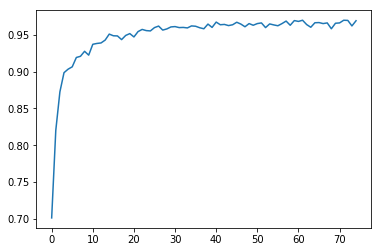

Model saved


In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    epochs = []
    v_accuracy = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})

        validation_accuracy = evaluate(X_valid, y_valid)
        epochs.append(i)
        v_accuracy.append(validation_accuracy)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    plt.plot(epochs, v_accuracy)
    plt.show()
    saver.save(sess, './lenet')
    print("Model saved")

### Validation accuracy results 

* **Validation accuracy achieved** : **0.969**
* **Best validation accuracy during training** : **0.97**

### Validation accuracy log

- Vanilla LeNet


|Batch Size|Epochs | Learning Rate | Preprocessing steps                  | Dropout present | Validation accuracy | Comments            |
|----------|:-----:|:-------------:|:------------------------------------:|:---------------:|:-------------------:|--------------------:|
|128       |30     | 0.001         | Grayscale, min-max scaling [0.1,0.9] | no              | ~ 0.91              |                     |
|128       |30     | 0.001         | Grayscale, quick normalization       | no              | ~ 0.92              |                     |
|128       |50     | 0.001         | Grayscale, quick normalization       | no              | ~ 0.92              |                     |
|128       |75     | 0.001         | Grayscale, standard normalization    | no              | > 0.93, < 0.95      | high accuracy jumps |
|128       |100    | 0.001         | Grayscale, standard normalization    | no              | > 0.93, < 0.95      | high accuracy jumps |
|128       |75     | 0.0009        | Grayscale, standard normalization    | no              | ~ 0.94              | low accuracy jumps  | 
|128       |75     | 0.0009        | Grayscale, standard normalization    | 0.5             | <= 0.964            | regularization!     | 
|128       |75     | 0.0009        | same as above + Augmented train (750)| 0.5             | ~ 0.964, 0.965      | Jitter pipeline!    | 
|128       |75     | 0.0009        | same as above + Augmented train (750)| 0.25            | ~ 0.917             |Activations did not generalize well| 
|256       |75     | 0.0009        | same as above + Augmented train (750)| 0.5             | ~ 0.962             |Higher batch size, no improvement| 
|128       |75     | 0.0009        | same as above + Augmented train (850)| 0.5             | ~ 0.969, 0.97       |extra 100 samples augmented!| 


- LeNet with few modifications inspired from Sermanet '11 paper on Traffic Sign classification.

|Batch Size|Epochs | Learning Rate | Preprocessing steps                  | Dropout present | Validation accuracy | Comments            |
|----------|:-----:|:-------------:|:------------------------------------:|:---------------:|:-------------------:|--------------------:|
|128       |75     | 0.0009        | graysclale,normalized,augmented (850)| 0.5             | ~ 0.957             |bit jumpy, no performance improvement with hacky implementation of Sermanet|  


- LeNet with one additional fully-connected layer, making it a total of 3 fully-connected layers.

|Batch Size|Epochs | Learning Rate | Preprocessing steps                  | Dropout present | Validation accuracy | Comments            |
|----------|:-----:|:-------------:|:------------------------------------:|:---------------:|:-------------------:|--------------------:|
|128       |75     | 0.0009        | graysclale,normalized,augmented (850)| 0.5             | ~ 0.955             |bit jumpy near highs, no performance improvement|  



#### Thoughts on CNN architectures

  1. To start out simple, classical LeNet was put into place with the following major components completely or 
    partially missing.
    * **Dropout** : Helps a lot as a regularization technique to remove dependency of the overall network 
    to a subset of neuron activations. 
    * **Data augmentation** : Number of samples spread across the class-labels is disproportionate. We know that
    deep-neural-nets perform really well majorly because of their ability to identify patterns/features in the data.
    Having non-uniform number of samples distributed across the class-labels would definitely underfit or overfit
    the model. This became a **crucial pipeline** to apply to improve the model's performance. Also this pipeline
    took quite a while (~ 10 minutes) for maintaining a minimum of 850 samples per class-label. I believe 
    the performance could definitely be increased by having at least 3000 samples per class-label.
    * **Normalization technique** : Min-max scaling was used and didn't seem to perform well. Coming to think of it, it
    applies a global-threshold-bound on the pixel values which is good for the training-routine to converge faster
    but doing so might cost on the *convolutional* model to miss out on certain features.
    
  2. Once a basic LeNet was found to be working well with regards to validation accuracy,
    architecture from Sermanet '11 paper on Traffic Sign Classification was tried. To compare the approaches, two major differences are seen : 
      1. They had used images in YUV spectrum, whereas this model used grayscale. 
      2. In their work, convolutions from 2nd stage/layer were being passed to the classifier as well as the
      flattened outputs from layer 1 and layer 2 were included. In my model, convolutions from 2nd layer, flattened,
      and outputs from 1st layer were together passed to the classifier.
   
    This architecture didn't perform better than the previous version though.

### Testing routine

In [48]:
model_path = './lenet'
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(model_path + '.meta')
    saver.restore(sess, model_path)
    test_accuracy = evaluate(X_test, y_test)
print('Test accuracy {:.3f}'.format(test_accuracy))

Test accuracy 0.948


### Test accuracy result

**Accuracy achieved in the test-set** : **0.948**

---

## Step 3: Testing the Model on New Images

### Load and Output the Images

Eight images on German traffic signs were downloaded from the Internet and
the model from above was run on classifying these images. Below given are the results of this classification.

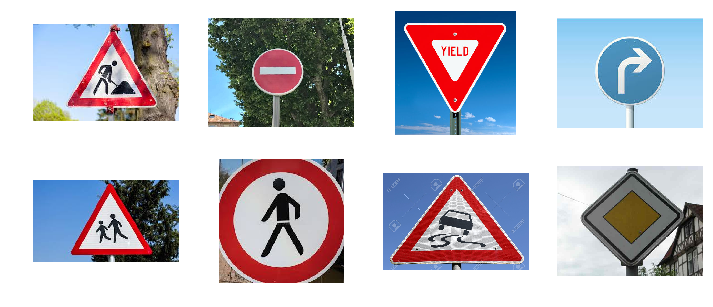

In [49]:
### Load the images and plot them here.
def load_test_images(path='dataset/test_images/*.jpg'):
    test_images = []
    test_images_scaled = []
    fig, ax = plt.subplots(2, 4, figsize=(12,5))
    ax = ax.ravel()
    for i, img in enumerate(glob.glob(os.getcwd()+'/'+path)):
        image = cv2.imread(img)
        ax[i].axis('off')
        ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        test_images.append(image)
        test_images_scaled.append(cv2.resize(image, (32,32)))
    return np.asarray(test_images), np.asarray(test_images_scaled)

test_images, test_images_scaled = load_test_images()
test_labels = [25, 17, 13, 33, 28, 27, 23, 12]

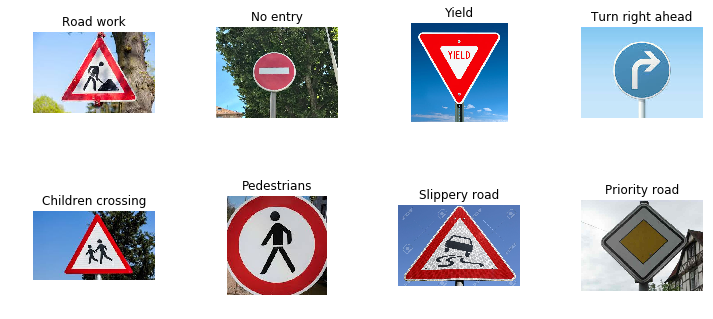

In [50]:
# Display test images with their label names.
fig, ax = plt.subplots(2, 4, figsize=(12,5))
fig.subplots_adjust(hspace=.75, wspace=.5)
ax = ax.ravel()
for i in range(len(test_images)):
    ax[i].axis('off')
    ax[i].set_title(sign_names[test_labels[i]])
    ax[i].imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))

### Predicting the Sign Type for Each Image

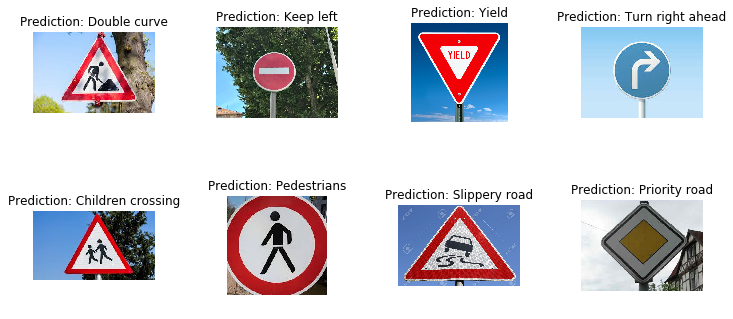

In [51]:
def predict(image, model):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(model + '.meta')
        saver.restore(sess, model)
        prediction = tf.argmax(logits, 1)
        return prediction.eval(feed_dict={x: image[np.newaxis,:,:,:], keep_prob: 1.0})
    
test_images_normalized = preprocess_images(test_images_scaled)

# Display predictions.
fig, ax = plt.subplots(2, 4, figsize=(12,5))
fig.subplots_adjust(hspace=.75, wspace=.5)
ax = ax.ravel()
for i in range(len(test_images)):
    prediction = predict(test_images_normalized[i], model_path)
    prediction = np.asscalar(prediction)
    ax[i].axis('off')
    ax[i].set_title("Prediction: " + sign_names[prediction])
    ax[i].imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))

### Analyzing Performance of Prediction

Above prediction on eight road signs show the following:
    
  * There is an accuracy of 0.875 i.e. 87.5%, for a (fairly) random set of eight images. This is far lower
  than the accuracies achieved on test and validation sets. Further probing on the types of (top-k) class-labels 
  returned by the classifier is covered in the next section.

  * **Road work** sign (class number 25) is misclassified as **Double curve**.
    
  * **No entry** sign (class number 17) is misclassified as **Keep left**.


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [52]:
def print_top_k_softmax(test_image, model, k=5):
    '''
    Returns the top-k class-labels predicted on a test-image with a given model.
    '''
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(model + '.meta')
        saver.restore(sess, model)
        # Softmax predictions on this test-image.
        softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: test_image[np.newaxis,:,:,:], keep_prob: 1.0})
        # Return top-k softmax probabilities predicted on this test-image.
        return sess.run(tf.nn.top_k(softmax, k))

def print_softmax_predictions(pred):
    '''
    Prints softmax-predictions in ascending order, with the class-label having the highest (softmax) 
    probability on top.
    '''
    # Index 0 has tuple of probabilities.
    # Index 1 has tuple of class-label indices.
    for i in range(len(pred[0][0])):
        print('{} : {:.3f}%'.format(sign_names[pred[1][0][i]], pred[0][0][i] * 100))

### Softmax prediction on Road work sign

Below softmax probabilities have **Road work** sign on number 3 with 11.633% confidence of classifying it correctly. 
The model believes it to be a **Double curve** sign with a higher probability, and hence the top one, with 70.8%
confidence.

Following shows a **Double curve** and **Dangerous curve to the left** signs which the classifier predicts
with greater confidence than its correct class **Road work**.

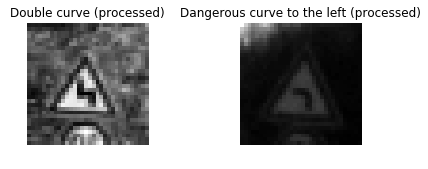

In [66]:
dcurve_indices = np.where(21 == y_test)  # Class number of a Double curve road-sign is 21.
dcurve_idx = dcurve_indices[0][0]
dang_left_indices = np.where(19 == y_test)  # Class number of Dangerous curve to the left sign is 19.
dang_left_idx = dang_left_indices[0][0]
fig,ax = plt.subplots(1,2)
plt.subplots_adjust(hspace=0.25, wspace=0.75)
ax[0].axis('off')
ax[0].set_title('Double curve (processed)')
ax[0].imshow(X_test[dcurve_idx].squeeze(), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Dangerous curve to the left (processed)')
ax[1].imshow(X_test[dang_left_idx].squeeze(), cmap='gray')

In [53]:
# Predictions for Road-work sign.
softmax_predictions = print_top_k_softmax(test_images_normalized[0], model_path)
print('Softmax predictions for Road Work sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Road Work sign..
Double curve : 70.843%
Dangerous curve to the left : 12.046%
Road work : 11.633%
Wild animals crossing : 3.238%
Slippery road : 1.756%


**Notes**: Above misclassified images look close to the **Road work** sign, something that the classifier could
become better at.

### Softmax prediction on No entry sign

Following softmax probabilities show no sign of classifying **No entry** sign correctly. Thoughts on this prediction
are as follows.

  * One intuitive case for this to happen is when the classifier didn't train well enough on **No entry** sign's features. The number of train-samples belonging to this class is 990, well below the maximum number of samples for any given class at around 2100. Adding the jitter-pipeline where images are augmented to the training set did improove the validation accuracy. For the classifier to predict well on classes of this type having less samples, augmenting more images (~4000 samples per class) could be a potential improvement.
  
  * The other top-4 classes predicted for this sign all share about equal softmax probabilities. Hence we can tell that the classifier is very poor in identifying images belonging to this class.

In [68]:
# Predictions for No entry sign.
softmax_predictions = print_top_k_softmax(test_images_normalized[1], model_path)
print('Softmax predictions for Stop sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Stop sign..
Keep left : 20.843%
Turn left ahead : 16.696%
Roundabout mandatory : 16.644%
Go straight or left : 11.567%
Turn right ahead : 6.615%


### Softmax prediction on Yield sign

Below prediction shows that the classifier is very confident in identifying images of **Yield** traffic-sign.

In [70]:
softmax_predictions = print_top_k_softmax(test_images_normalized[2], model_path)
print('Softmax predictions for Yield sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Yield sign..
Yield : 100.000%
No vehicles : 0.000%
Priority road : 0.000%
Speed limit (60km/h) : 0.000%
Speed limit (50km/h) : 0.000%


### Softmax predictions on rest of the images

From the predictions below, we see that the classifier performs well on classes of certain type (Children crossing, 
Slippery road, Priority road) and just manages to predict correctly the other classes (Turn Right Ahead, Pedestrians).
This is good news since we have lots of room for improvement as addressed in the *Reflections* sections below.

In [71]:
softmax_predictions = print_top_k_softmax(test_images_normalized[3], model_path)
print('Softmax predictions for Turn Right Ahead sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Turn Right Ahead sign..
Turn right ahead : 54.138%
Turn left ahead : 13.802%
Roundabout mandatory : 9.673%
Stop : 5.354%
Vehicles over 3.5 metric tons prohibited : 4.706%


In [72]:
softmax_predictions = print_top_k_softmax(test_images_normalized[4], model_path)
print('Softmax predictions for Children Crossing sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Children Crossing sign..
Children crossing : 99.153%
Traffic signals : 0.412%
Pedestrians : 0.301%
Bumpy road : 0.098%
Dangerous curve to the right : 0.030%


In [73]:
softmax_predictions = print_top_k_softmax(test_images_normalized[5], model_path)
print('Softmax predictions for Pedestrians sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Pedestrians sign..
Pedestrians : 51.652%
Traffic signals : 25.533%
Road narrows on the right : 20.355%
General caution : 1.440%
Double curve : 0.988%


In [74]:
softmax_predictions = print_top_k_softmax(test_images_normalized[6],  model_path)
print('Softmax predictions for Slippery Road sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Slippery Road sign..
Slippery road : 99.971%
Dangerous curve to the left : 0.029%
Bumpy road : 0.000%
Beware of ice/snow : 0.000%
Double curve : 0.000%


In [75]:
softmax_predictions = print_top_k_softmax(test_images_normalized[7], model_path)
print('Softmax predictions for Priority Road sign..')
print_softmax_predictions(softmax_predictions)

Softmax predictions for Priority Road sign..
Priority road : 100.000%
Roundabout mandatory : 0.000%
Speed limit (100km/h) : 0.000%
No vehicles : 0.000%
No passing : 0.000%


## Reflections

### Potential improvements

  1. **Data augmentation** : Adding more data for the training routine will definitely help improving the model. 
    This routine could be handed down to existing frameworks like Keras which provides ImageDataGenerator. A good
    number for the minimum number of samples could be 4000, making it a total of 172000 training samples for all
    the classes combined, compared to existing number of ~ 47000.

  2. **Image pre-processing** : Current approach uses plain grayscale images and normalizes them.
    * Better approach would be to endure that images have zero-mean and uniform standard-deviation for the model
    to converge faster. 
    * Also other pre-processing techniques like blurring the images could be helpful since that'd replicate
    real-world data taken from a camera mounted on a moving vehicle. 
    * Using the images in a space other than grayscale e.g. YUV color-space could be a potential improvement.
    In this case the Y channel could be normalized as it holds the brightness-knob of the image, leaving the other
    two channels, U and V related to the color components, unchanged.
    * Increasing the contrast in the images could help the convolutions to pick up features which are significant.
    This could be done with [Adaptive Historgram Equalization](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization).
    
  3. **Regularization** : Dropout is the only regularization mechanism currently being used. Adding L2 regularization
    would add penalties on the weights if they're grow too large, directly leading the model to keep their values
    bounded and hence avoiding overfitting as much as possible.
    
  4. **Hyperparameter tuning** : Instead of tuning hyperparameters by hand e.g. making the *learning-rate* go up or 
  down, **grid-search** could be used where we the model would be automated to look for the best values falling in 
  a given range.